In [1]:
import nltk
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
import pandas as pd

pd.set_option('display.max_columns', None)  # Tampilkan semua kolom
pd.set_option('display.max_rows', 100)      # Bisa disesuaikan untuk baris
pd.set_option('display.width', None)        # Biarkan lebar layar fleksibel
pd.set_option('display.max_colwidth', None) # Tampilkan isi kolom panjang


# Text Preprocessing

In [3]:

df = pd.read_csv('df_en.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10931 entries, 0 to 10930
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.2    10931 non-null  int64 
 1   Unnamed: 0.1    10931 non-null  int64 
 2   Unnamed: 0      10931 non-null  int64 
 3   full_text       10931 non-null  object
 4   text_processed  10931 non-null  object
 5   text_en         10931 non-null  object
 6   label           10931 non-null  object
dtypes: int64(3), object(4)
memory usage: 597.9+ KB


In [38]:
df.tail()

,Unnamed: 0,full_text,label,text_processed,text_processed1,score,panjang
5249,NaN,Mahfud MD meyakini Pemerintahan Bersih berproses di bawah Presiden Prabowo Subianto @prabowo Keseriusannya dibuktikan di lapangan Para menteri berani ungkap bongkar dan lawan kejahatan para oknum dan mafia Saatnya negara minus mafia hukum korupsi dan rakyat sejahtera https://t.co/vl72m964em,neutral,mahfud perintah bersih proses presiden prabowo subianto prabowo serius bukti lapang menteri berani bongkar lawan jahat oknum mafia negara minus mafia hukum korupsi rakyat sejahtera,mahfud md meyakini pemerintahan bersih berproses di bawah presiden prabowo subianto prabowo keseriusannya dibuktikan di lapangan para menteri berani ungkap bongkar dan lawan kejahatan para oknum dan mafia saatnya negara minus mafia hukum korupsi dan rakyat sejahtera,0.989115,25.0
5250,NaN,Semoga Presiden Prabowo dapat mengambil tindakan yg bijak untuk menyelesaikan masalah ini scr TUNTAS sesuai tuntutan nurani rakyat. https://t.co/GDN6y0lBui #batalkanPSNPIK2,positive,moga presiden prabowo ambil tindak bijak selesai scr tuntas sesuai tuntut nurani rakyat batalkanpsnpik,semoga presiden prabowo dapat mengambil tindakan yang bijak untuk menyelesaikan masalah ini scr tuntas sesuai tuntutan nurani rakyat batalkanpsnpik,0.903417,14.0
5251,NaN,FUFUFAFA adalah Bencana Nasional untuk Indonesia FUFUFAFA adalah Bencana tak berkesudahan untuk Presiden @prabowo dan keluarga. Kalau perbuatan sadis dan amoral seperti ini dibiarkan begitu saja tanpa tindakan Maka Anak-Anak Milenial dan Gen Z akan mendapat PEMBENARAN untuk https://t.co/tKgFWwbXK4,negative,fufufafa bencana nasional indonesia fufufafa bencana sudah presiden prabowo keluarga buat sadis amoral biar tindak anak anak milenial gen benar,fufufafa adalah bencana nasional untuk indonesia fufufafa adalah bencana tak berkesudahan untuk presiden prabowo dan keluarga kalau perbuatan sadis dan amoral seperti ini dibiarkan begitu saja tanpa tindakan maka anak anak milenial dan gen akan mendapat pembenaran untuk,0.988838,20.0
5252,NaN,Kita beri waktu bagi bapak Presiden @prabowo dalam seratus hari kerjanya untuk menangkap para pelaku pembantaian Rakyat plus Perampok uang Rakyat jika tidak dilakukannya maka suara yang kita gaungkan yaitu Gulingkan Prabowo . Yang setuju Retweet aja sampai ke pak @prabowo . https://t.co/RIir4SU006,positive,presiden prabowo ratus kerja tangkap laku bantai rakyat plus rampok uang rakyat laku suara gaung guling prabowo tuju retweet prabowo,kita beri waktu bagi bapak presiden prabowo dalam seratus hari kerjanya untuk menangkap para pelaku pembantaian rakyat plus perampok uang rakyat jika tidak dilakukannya maka suara yang kita gaungkan yaitu gulingkan prabowo yang setuju retweet aja sampai ke pak prabowo,0.953375,20.0
5253,NaN,Kunker pertama Presiden Prabowo ke luar negeri beserta rombongan telah tiba di China https://t.co/X0OV9DfaGl,neutral,kunker presiden prabowo negeri serta rombong china,kunker pertama presiden prabowo ke luar negeri beserta rombongan telah tiba di china,0.985573,7.0


In [39]:
df = df.drop(
    df[df['label'] == 'neutral'].sample(n=2000, random_state=42).index
).reset_index(drop=True)


In [4]:
df['label'].value_counts()

label
Positif    5260
Netral     3891
Negatif    1780
Name: count, dtype: int64

In [5]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Inisialisasi stemmer dan stopwords
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))

# Mention penting yang ingin disimpan (whitelist)
mention_whitelist = ['prabowo']

# Kamus normalisasi kata informal → formal
normalisasi_kata = {
    'gak': 'tidak',
    'ga': 'tidak',
    'yg': 'yang',
    'utk': 'untuk',
    'dgn': 'dengan',
    'apik': 'baik',
    'sdh': 'sudah',
    'krn': 'karena',
    'apik': 'bagus',
    'tdk': 'tidak',
    'klo': 'kalo',
    'sbg': 'sebagai',
    'gue': 'aku',
    'aja': '',
    'amp': '',
    'nya': '',
    'ya': '',
    'gitu': '',
    'loh': '',
    'dong': '',
    'sih': '',
    'deh': '',
    'nih': '',
    'kok': '',
}

def preprocessing(text):
    # 2. Tangani mention: simpan jika ada di whitelist, hapus lainnya
    text = re.sub(r'@(\w+)', lambda m: m.group() if m.group(1).lower() in mention_whitelist else '', text)

    text = re.sub(r'http\S+|www\S+|<.*?>|#', ' ', text)
    
    # 4. Hapus tag HTML (jika ada)
    text = re.sub(r'<.*?>', '', text)

    # 5. Hapus karakter non-huruf (angka, simbol)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # 6. Lowercase
    text = text.lower()

    # 7. Tokenisasi
    tokens = word_tokenize(text)

    # 8. Normalisasi kata informal
    tokens = [normalisasi_kata.get(word, word) for word in tokens]

    # 9. Hapus stopwords dan kata kosong/panjang pendek
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2 and word != '']

    # 11. Gabung kembali jadi string
    return ' '.join(tokens)


In [6]:
def apply_with_progress(df, func, column, new_column, step=50):
    result = []
    for i, text in enumerate(df[column]):
        result.append(func(text))
        if (i + 1) % step == 0 or (i + 1) == len(df):
            print(f"Processed {i + 1}/{len(df)} rows")
    df[new_column] = result
    return df

# Contoh pemakaian
df = apply_with_progress(df, preprocessing, 'full_text', 'text_processed')
df.head()


Processed 50/10931 rows
Processed 100/10931 rows
Processed 150/10931 rows
Processed 200/10931 rows
Processed 250/10931 rows
Processed 300/10931 rows
Processed 350/10931 rows
Processed 400/10931 rows
Processed 450/10931 rows
Processed 500/10931 rows
Processed 550/10931 rows
Processed 600/10931 rows
Processed 650/10931 rows
Processed 700/10931 rows
Processed 750/10931 rows
Processed 800/10931 rows
Processed 850/10931 rows
Processed 900/10931 rows
Processed 950/10931 rows
Processed 1000/10931 rows
Processed 1050/10931 rows
Processed 1100/10931 rows
Processed 1150/10931 rows
Processed 1200/10931 rows
Processed 1250/10931 rows
Processed 1300/10931 rows
Processed 1350/10931 rows
Processed 1400/10931 rows
Processed 1450/10931 rows
Processed 1500/10931 rows
Processed 1550/10931 rows
Processed 1600/10931 rows
Processed 1650/10931 rows
Processed 1700/10931 rows
Processed 1750/10931 rows
Processed 1800/10931 rows
Processed 1850/10931 rows
Processed 1900/10931 rows
Processed 1950/10931 rows
Proces

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,full_text,text_processed,text_en,label
0,0,0,0,OK gas ...Indonesia Emas nih pak @prabowo @gibran_tweet l berkas kerja keras kalian kita memimpin klasemen pengangguran ke 1 di Asean. Kinerja kalian sangat memuaskan mayoritas para pengangguran. Siapa yang yg hendak kalian utus untuk menerima penghargaan ini ?,gas indonesia emas prabowo berkas kerja keras memimpin klasemen pengangguran asean kinerja memuaskan mayoritas pengangguran utus menerima penghargaan,Indonesia Gas Emas Prabowo Hard work file leads the ASEAN unemployment standings to satisfy the majority of Utus unemployment receiving awards,Negatif
1,1,1,1,@uglygrunge1798 @Heraloebss @prabowo @gibran_tweet Ngga ada hubungannya terpilihnya presiden dan wapres dengan kepuasan setelah mereka terpilih. Emangnya kalo sudah terpilih warga indonesia harus dipaksa puas gitu? Ya ngga lah. Kepuasan itu hubungannya dengan kinerja setelah mereka terpilih. Kamu harus move on dari pemilu!,prabowo ngga hubungannya terpilihnya presiden wapres kepuasan terpilih emangnya kalo terpilih warga indonesia dipaksa puas ngga kepuasan hubungannya kinerja terpilih move pemilu,"Prabowo The relationship between the election of the president of the vice president of satisfaction was elected, the elected Indonesian citizens were forced to satisfied with the satisfaction",Positif
2,2,2,2,@DedynurPalakka Kinerja? Emang pernah dikasih tugas atau misi apa sm prabowo?,kinerja emang dikasih tugas misi prabowo,Performance is given the task of Prabowo's mission,Netral
3,3,3,3,@txtdrimedia Kinerja?? Emang dikasi tugas apa sm prabowo?,kinerja emang dikasi tugas prabowo,Prabowo's task of performance,Netral
4,4,4,4,@uglygrunge1798 @Heraloebss @prabowo @gibran_tweet Demokrasi dan tupoksi kinerja NDASMU pemimpin yg tdk bisa me-manage bawahan mk hsl kerja tdk benar,prabowo demokrasi tupoksi kinerja ndasmu pemimpin manage bawahan hsl kerja,Prabowo Democracy Tupoksi Performance Ndasmu Leader Manage Subordinate HSL Work,Netral


In [7]:
df.tail()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,full_text,text_processed,text_en,label
10926,10926,10926,12208,Ini bukti susu gratis @gibran_tweet proyek bisnis titipan para makelar bisnis yg juga bagian dari pembusukan presiden @prabowo Oleh kabinetnya sendiri . Petani susu di matikan. https://t.co/3bQUGnkIec,bukti susu gratis proyek bisnis titipan makelar bisnis pembusukan presiden prabowo kabinetnya petani susu matikan,"Proof of Free Milk Business Project entrusted business entrusted business decay of president Prabowo, the cabinet is a milk farmer turn off",Positif
10927,10927,10927,12209,Kita beri waktu bagi bapak Presiden @prabowo dalam seratus hari kerjanya untuk menangkap para pelaku pembantaian Rakyat plus Perampok uang Rakyat jika tidak dilakukannya maka suara yang kita gaungkan yaitu Gulingkan Prabowo . Yang setuju Retweet aja sampai ke pak @prabowo . https://t.co/RIir4SU006,presiden prabowo seratus kerjanya menangkap pelaku pembantaian rakyat plus perampok uang rakyat dilakukannya suara gaungkan gulingkan prabowo setuju retweet prabowo,President Prabowo one hundred work arrested the perpetrators of the massacre of the people plus the robber of public money he did the vote echoing Prabowo agreed to Retweet Prabowo,Netral
10928,10928,10928,12210,Kunker pertama Presiden Prabowo ke luar negeri beserta rombongan telah tiba di China https://t.co/X0OV9DfaGl,kunker presiden prabowo negeri beserta rombongan china,Kunker President Prabowo Negeri and China's entourage,Netral
10929,10929,10929,12211,Presiden Prabowo Subianto tiba di Beijing China didampingi putranya Didit Hediprasetyo dalam lawatan pertamanya sebagai kepala negara ke luar negeri. https://t.co/mnmqDhJ57u,presiden prabowo subianto beijing china didampingi putranya didit hediprasetyo lawatan pertamanya kepala negara negeri,President Prabowo Subianto Beijing China was accompanied by his son Didit Hediprasetyo his first visit to the Head of State State,Positif
10930,10930,10930,12212,. . Presiden Prabowo TIDAK mendelegasikan Tugas ke Wapres .. Mentri diminta KONTAK LANGSUNG ke Presiden saat Presiden di Luar Negeri Nah .. Kemaren kan Buzzer Mulyono gembar-gembor katanya Gibran bakal jadi PLT PRESIDEN .. Trus itu juga DIBANTAH langsung sama ISTANA Jadi Pak https://t.co/HiiIBb2YCQ,presiden prabowo mendelegasikan tugas wapres mentri kontak langsung presiden presiden negeri kemaren buzzer mulyono gembar gembor gibran plt presiden trus dibantah langsung istana,President Prabowo delegates the duties of the Vice -President Direct of Direct contact of the president of the country yesterday Buzzer Mulyono is a fanfare Gibran Gibran Acting President then denied the palace directly,Positif


In [8]:
from collections import Counter
import re

df_copy = df.copy()

# Gabungkan semua teks jadi satu string
text = ' '.join(df_copy['text_processed'].astype(str))

# Preprocessing: lowercase + tokenisasi
words = re.findall(r'\b\w+\b', text.lower())

# Hitung frekuensi kata
freq = Counter(words)

# Ambil 50 kata paling sering
top_50 = freq.most_common(150)

# Cetak hasil
for word, count in top_50:
    print(f"{word}: {count}")


prabowo: 12305
presiden: 6304
kinerja: 5908
rakyat: 2182
kabinet: 2130
indonesia: 1568
bagus: 1317
menteri: 1313
gibran: 1216
subianto: 1075
jokowi: 1050
masyarakat: 869
negara: 816
puas: 745
pemerintahan: 711
kerja: 710
publik: 598
survei: 595
bikin: 557
kebijakan: 531
pemerintah: 504
program: 501
orang: 496
kinerjaprabowoterbukti: 463
hasil: 461
nyata: 447
kalo: 405
tni: 365
anak: 352
korupsi: 319
kepuasan: 318
ekonomi: 316
harikerjanyata: 315
hukum: 309
visi: 307
polri: 306
bumn: 305
kesejahteraan: 302
banget: 280
langsung: 272
keras: 262
omon: 262
bangsa: 259
positif: 257
makan: 256
tuh: 251
kepala: 245
udah: 242
politik: 240
beliau: 231
gratis: 231
kasih: 223
pejabat: 221
salah: 221
negeri: 220
mulyono: 216
koruptor: 215
apresiasi: 213
semoga: 206
langkah: 197
keadilan: 194
maju: 191
fokus: 189
merah: 188
bener: 187
dunia: 184
evaluasi: 183
bilang: 179
anggaran: 175
percaya: 174
tingkat: 173
khusus: 173
hidup: 172
ketua: 172
jakarta: 171
putih: 171
pemimpin: 170
menterinya: 170
te

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# df1 = df.copy()
# df1['panjang'] = df1['text_processed'].apply(lambda x: len(x.split()))
sns.histplot(df['panjang'], bins=30)

KeyError: 'panjang'

In [10]:
import pandas as pd

# Misal df1 dan df2 sudah ada dan punya kolom yang sama
df['label_num'] = df['label'].replace({'Netral' : 0, 'Positif' : 1, 'Negatif' : 2})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10931 entries, 0 to 10930
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.2    10931 non-null  int64 
 1   Unnamed: 0.1    10931 non-null  int64 
 2   Unnamed: 0      10931 non-null  int64 
 3   full_text       10931 non-null  object
 4   text_processed  10931 non-null  object
 5   text_en         10931 non-null  object
 6   label           10931 non-null  object
 7   label_num       10931 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 683.3+ KB


In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

# 1. Inisialisasi dan fit tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text_processed'])

# 2. Tentukan MAX_WORDS berdasarkan jumlah kata unik
total_kata_unik = len(tokenizer.word_index)
print("Jumlah kata unik:", total_kata_unik)

# Atur MAX_WORDS agar tidak terlalu besar
if total_kata_unik > 20000:
    MAX_WORDS = 15000
elif total_kata_unik > 10000:
    MAX_WORDS = total_kata_unik
else:
    MAX_WORDS = total_kata_unik

print("MAX_WORDS yang digunakan:", MAX_WORDS)

Jumlah kata unik: 18087
MAX_WORDS yang digunakan: 18087


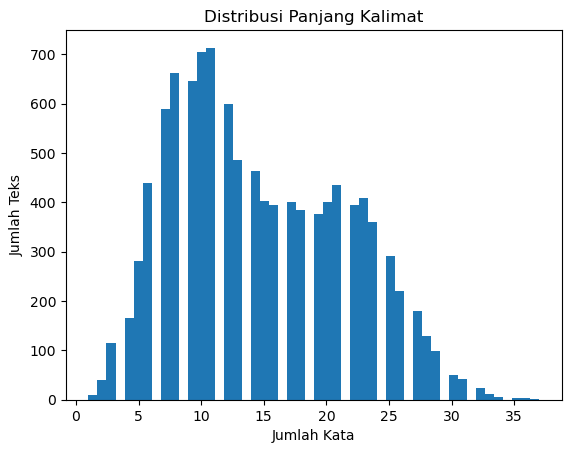

MAX_LEN (persentil 95): 37


In [12]:
# 3. Hitung panjang tiap kalimat
sequences = tokenizer.texts_to_sequences(df['text_processed'])
panjang_kalimat = [len(seq) for seq in sequences]

# 4. Tentukan MAX_LEN berdasarkan distribusi panjang
plt.hist(panjang_kalimat, bins=50)
plt.title('Distribusi Panjang Kalimat')
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Teks')
plt.show()

MAX_LEN = int(np.percentile(panjang_kalimat, 100))
print("MAX_LEN (persentil 95):", MAX_LEN)

In [13]:
# 5. Lakukan ulang tokenizer dengan batasan MAX_WORDS
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text_processed'])
sequences = tokenizer.texts_to_sequences(df['text_processed'])

# 6. Padding sequences
padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# Feature Engineering

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    padded, df['label_num'], test_size=0.3, random_state=42, stratify=df['label_num']
)
y_train.value_counts(), y_test.value_counts()

(label_num
 1    3682
 0    2723
 2    1246
 Name: count, dtype: int64,
 label_num
 1    1578
 0    1168
 2     534
 Name: count, dtype: int64)

# Model Architecture Definition

# Training Model

In [15]:
import numpy as np
print(np.unique(y_train, return_counts=True))  # Cek distribusi kelas

(array([0, 1, 2], dtype=int64), array([2723, 3682, 1246], dtype=int64))


In [16]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.9365895458440445, 1: 0.6926489226869454, 2: 2.046816479400749}

In [17]:
import numpy as np
from gensim.models import KeyedVectors

# Load model FastText Bahasa Indonesia
fasttext_model = KeyedVectors.load_word2vec_format('cc.id.300.vec', limit=50000)  # optional limit

# Buat embedding matrix
embedding_dim = 300
embedding_matrix = np.zeros((MAX_WORDS, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < MAX_WORDS:
        if word in fasttext_model:
            embedding_matrix[i] = fasttext_model[word]
        else:
            embedding_matrix[i] = np.random.normal(0, 0.1, embedding_dim)  # fallback


In [18]:
from keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional  
from keras import regularizers  
from keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.metrics import Recall, Precision
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


model = Sequential()
model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_dim, 
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=True))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

# Layer GRU kedua
model.add(LSTM(32))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(3, activation='softmax'))

# Kompilasi model dengan learning rate yang lebih kecil
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer= RMSprop(learning_rate=0.0005),
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Callback ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',         # Nama file model yang disimpan
    monitor='val_loss',               # Metrik yang dipantau
    save_best_only=True,             # Simpan hanya model terbaik
    mode='min',                      # Karena kita ingin meminimalkan val_loss
    verbose=1                        # Tampilkan log penyimpanan
)

# Callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  
    restore_best_weights=True
)
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    class_weight=class_weights  
)

Epoch 1/100
120/120 [==============================] - ETA: 0s - loss: 1.0098 - accuracy: 0.4135
Epoch 1: val_loss improved from inf to 0.93051, saving model to best_model.h5
120/120 [==============================] - 26s 121ms/step - loss: 1.0098 - accuracy: 0.4135 - val_loss: 0.9305 - val_accuracy: 0.5427 - lr: 5.0000e-04
Epoch 2/100
120/120 [==============================] - ETA: 0s - loss: 0.7486 - accuracy: 0.6540
Epoch 2: val_loss improved from 0.93051 to 0.76555, saving model to best_model.h5
120/120 [==============================] - 12s 100ms/step - loss: 0.7486 - accuracy: 0.6540 - val_loss: 0.7655 - val_accuracy: 0.6634 - lr: 5.0000e-04
Epoch 3/100
120/120 [==============================] - ETA: 0s - loss: 0.5272 - accuracy: 0.7858
Epoch 3: val_loss did not improve from 0.76555
120/120 [==============================] - 12s 101ms/step - loss: 0.5272 - accuracy: 0.7858 - val_loss: 0.7737 - val_accuracy: 0.6887 - lr: 5.0000e-04
Epoch 4/100
120/120 [============================

In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

model = Sequential()
model.add(Embedding(
    input_dim=embedding_matrix.shape[0], 
    output_dim=embedding_dim, 
    weights=[embedding_matrix],
    input_length=MAX_LEN,
    trainable=False))  # Matriks embedding dibekukan (tidak di-training)

# Menggunakan Bidirectional LSTM dengan regularisasi L2
model.add((LSTM(128, return_sequences=True, 
                          kernel_regularizer=regularizers.l2(0.01))))
model.add(Dropout(0.3))  # Meningkatkan dropout

# Layer LSTM kedua
model.add((LSTM(64, kernel_regularizer=regularizers.l2(0.01))))
model.add(Dropout(0.3))

# Menambahkan dense layer dengan regularisasi
model.add(Dense(32, activation='relu', 
              kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(3, activation='softmax'))

# Early Stopping yang lebih agresif
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Mengurangi kesabaran
    min_delta=0.001,  # Perubahan minimal untuk dianggap sebagai peningkatan
    restore_best_weights=True
)

# # Menambahkan pengurangan learning rate otomatis
# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.2,
#     patience=3,
#     min_lr=1e-6,
#     verbose=1
# )

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.001),  # Learning rate lebih rendah
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    batch_size=32,  # Ukuran batch lebih kecil
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    class_weight=class_weights
)

Epoch 1/100
240/240 [==============================] - ETA: 0s - loss: 1.7364 - accuracy: 0.3518
Epoch 1: val_loss did not improve from 0.76555
240/240 [==============================] - 38s 100ms/step - loss: 1.7364 - accuracy: 0.3518 - val_loss: 1.0915 - val_accuracy: 0.4290 - lr: 0.0010
Epoch 2/100
240/240 [==============================] - ETA: 0s - loss: 1.0848 - accuracy: 0.4100
Epoch 2: val_loss did not improve from 0.76555
240/240 [==============================] - 21s 89ms/step - loss: 1.0848 - accuracy: 0.4100 - val_loss: 1.0559 - val_accuracy: 0.4543 - lr: 0.0010
Epoch 3/100
240/240 [==============================] - ETA: 0s - loss: 1.0552 - accuracy: 0.4402
Epoch 3: val_loss did not improve from 0.76555
240/240 [==============================] - 22s 90ms/step - loss: 1.0552 - accuracy: 0.4402 - val_loss: 1.7200 - val_accuracy: 0.3857 - lr: 0.0010
Epoch 4/100
240/240 [==============================] - ETA: 0s - loss: 1.0408 - accuracy: 0.4722
Epoch 4: val_loss did not improv

KeyboardInterrupt: 

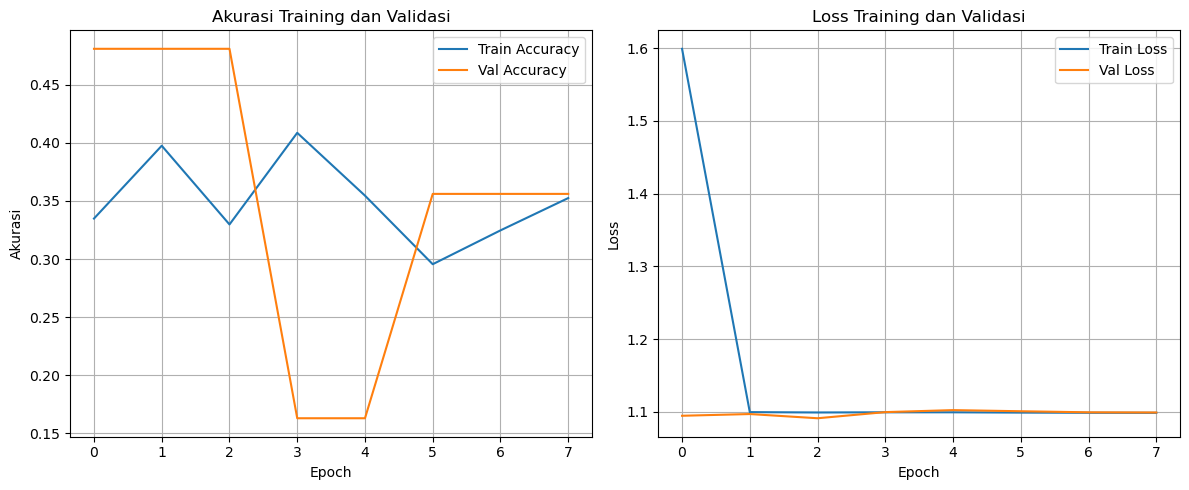

In [20]:
import matplotlib.pyplot as plt

# Ambil data dari history
history_dict = history.history

# --- Plot Accuracy ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# --- Plot Loss ---
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [21]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load model terbaik
best_model = load_model("best_model.h5")

# Prediksi dengan model terbaik
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_names = ['Netral', 'Positif', 'Negatif']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix dari Best Model')
plt.show()

# Laporan klasifikasi
print(classification_report(y_test, y_pred, target_names=class_names))


ValueError: in user code:

    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_25" is incompatible with the layer: expected shape=(None, 36), found shape=(None, 37)


In [58]:
y_train[:5]

3762    1
2063    0
3818    0
3049    2
589     1
Name: label_num, dtype: int64